# Exercises

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [8]:
#GENERATE DATA
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)


In [9]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})
#download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/gOwG6DKD7IpkPze')
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

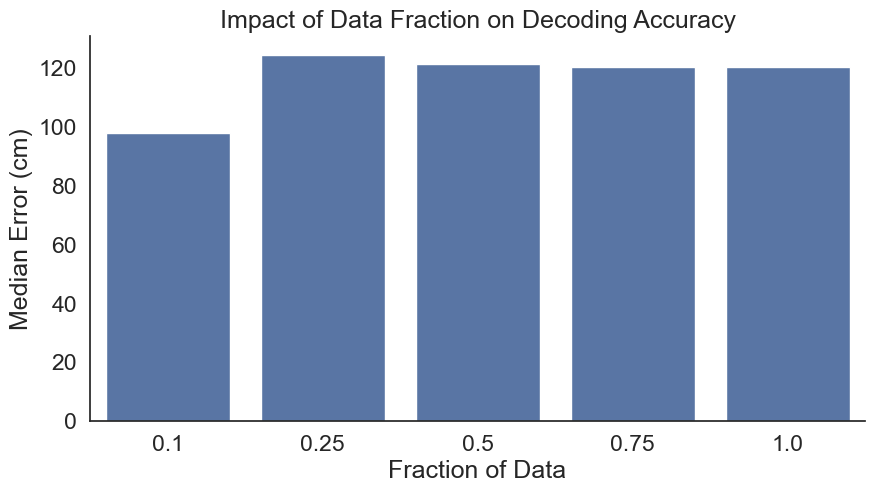

In [11]:
#PART A
from scipy.stats import poisson
# Compute firing rate maps
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.)
spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)
occupancy = np.histogram(x, space_bins)[0] / fps
firing_rate_maps = spikes_hist / occupancy

# Function to decode position
def decode_position(spikes_count, firing_rate_maps, space_bins):
    x_decoded = np.zeros(spikes_count.shape[0])
    for t_bin in range(spikes_count.shape[0]):
        if sum(spikes_count[t_bin,:]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:], firing_rate_maps[:,i]))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
    return x_decoded

# Sub-sample data and compute median error
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
errors = []

for fraction in fractions:
    sample_size = int(fraction * len(t))
    indices = np.sort(np.random.choice(len(t), sample_size, replace=False))
    sampled_t = t[indices]
    sampled_x = x[indices]

    # Create sub-sampled spike data
    sampled_spikes = []
    for s in spikes:
        sampled_spikes.append(s[np.isin(s, sampled_t)])
    
    # Bin the spikes in the sampled time points
    spikes_count = [np.histogram(s, sampled_t)[0] for s in sampled_spikes]
    spikes_count = np.asarray(spikes_count).T
    
    true_x = sampled_x[:len(spikes_count)]  # Ensure lengths match
    decoded_x = decode_position(spikes_count, firing_rate_maps, space_bins)
    
    mse = np.sqrt((true_x - decoded_x)**2)
    median_error = np.nanmedian(mse)
    errors.append(median_error)

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=fractions, y=errors)
plt.xlabel('Fraction of Data')
plt.ylabel('Median Error (cm)')
plt.title('Impact of Data Fraction on Decoding Accuracy')
plt.show()

How does the median error change when the the number of available sample gets larger? When the number of available samples increases, the median error stabilizes. This may suggest that having more data improves decoding accuracy up to a certain point, after which additional data does not significantly enhance performance. 

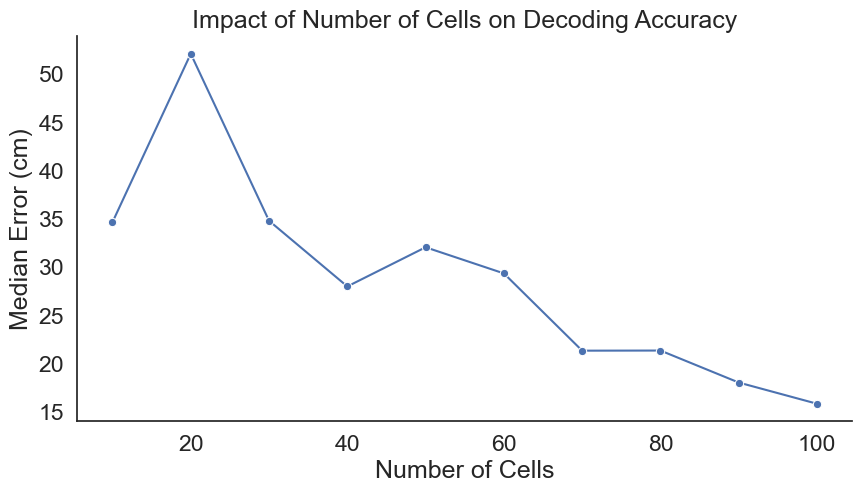

In [12]:
# PART B
# Subset sizes and number of trials
cell_subsets = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_trials = 10
errors = {subset: [] for subset in cell_subsets}

for subset in cell_subsets:
    for _ in range(n_trials):
        selected_cells = np.random.choice(n_cells, subset, replace=False)
        subset_spikes = [spikes[i] for i in selected_cells]
        subset_firing_rate_maps = firing_rate_maps[selected_cells]

        # Bin the spikes in the original time points
        spikes_count = [np.histogram(s, t)[0] for s in subset_spikes]
        spikes_count = np.asarray(spikes_count).T

        true_x = x[:len(spikes_count)]  # Ensure lengths match
        decoded_x = decode_position(spikes_count, subset_firing_rate_maps, space_bins)

        mse = np.sqrt((true_x - decoded_x)**2)
        median_error = np.nanmedian(mse)
        errors[subset].append(median_error)

# Compute average errors
avg_errors = [np.mean(errors[subset]) for subset in cell_subsets]

# Plot the results
plt.figure(figsize=(10, 5))
sns.lineplot(x=cell_subsets, y=avg_errors, marker='o')
plt.xlabel('Number of Cells')
plt.ylabel('Median Error (cm)')
plt.title('Impact of Number of Cells on Decoding Accuracy')
plt.show()


the median error decreases as the number of place cells used for decoding increases. Initially, the error decreases rapidly, indicating that the addition of more cells significantly improves decoding accuracy. However, beyond a certain point (around 60-70 cells), the improvement in accuracy begins to plateau, which can indicate that the median error reaches an asymptote. Therefore, to reliably decode the position, it appears that using around 60-70 cells is sufficient. Beyond this number, adding more cells does not significantly enhance the decoding accuracy. This plateau effect indicates that the decoder has enough information to make accurate predictions, and additional data contributes less to further improvements.

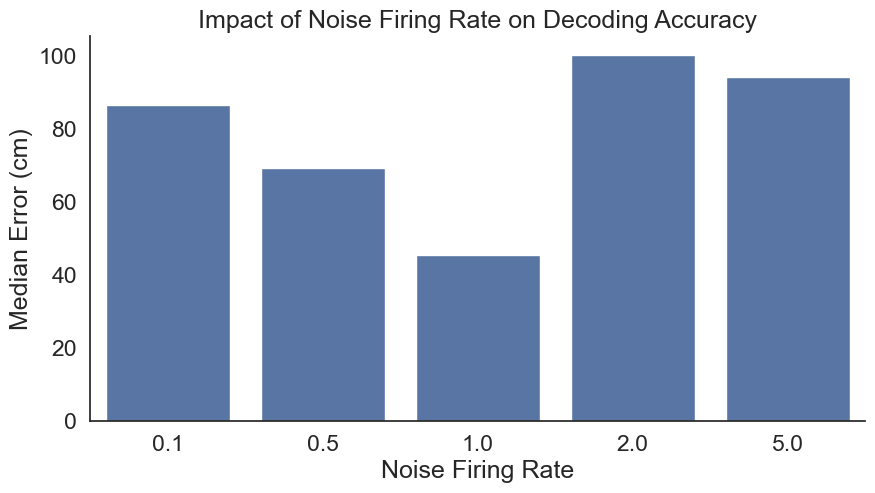

In [13]:
# PART C
# Varying levels of noise
noise_levels = [0.1, 0.5, 1.0, 2.0, 5.0]
errors_noise = []

for noise_firing_rate in noise_levels:
    # GENERATE DATA with different noise levels
    spikes = []
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps

    with open(f'data/linear_track_data_noise_{noise_firing_rate}.pickle', 'wb') as f:
        pickle.dump(out_data, f)
    
    # Load the newly generated data for decoding
    with open(f'data/linear_track_data_noise_{noise_firing_rate}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    x, t, spikes = data['x'], data['t'], data['spikes']

    # Compute firing rate maps
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy

    # Sub-sample data and compute median error
    sample_size = len(t)
    indices = np.sort(np.random.choice(len(t), sample_size, replace=False))
    sampled_t = t[indices]
    sampled_x = x[indices]

    # Create sub-sampled spike data
    sampled_spikes = []
    for s in spikes:
        sampled_spikes.append(s[np.isin(s, sampled_t)])
    
    # Bin the spikes in the sampled time points
    spikes_count = [np.histogram(s, sampled_t)[0] for s in sampled_spikes]
    spikes_count = np.asarray(spikes_count).T
    
    true_x = sampled_x[:len(spikes_count)]  # Ensure lengths match
    decoded_x = decode_position(spikes_count, firing_rate_maps, space_bins)
    
    mse = np.sqrt((true_x - decoded_x) ** 2)
    median_error = np.nanmedian(mse)
    errors_noise.append(median_error)

# Plot the results for different noise levels
plt.figure(figsize=(10, 5))
sns.barplot(x=noise_levels, y=errors_noise)
plt.xlabel('Noise Firing Rate')
plt.ylabel('Median Error (cm)')
plt.title('Impact of Noise Firing Rate on Decoding Accuracy')
plt.show()


Increasing the noise in the firing rate seems to worsens the decoding accuracy, as indicated by higher median errors. As the noise firing rate increases from 0.1 to 5.0, the median error initially decreases at 0.5 and 1.0, but increases significantly at higher noise levels (2.0 and 5.0). This suggests that moderate noise might be somewhat manageable, but higher noise levels severely impact the decoder's performance, making it less reliable in accurately predicting the animal's position.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




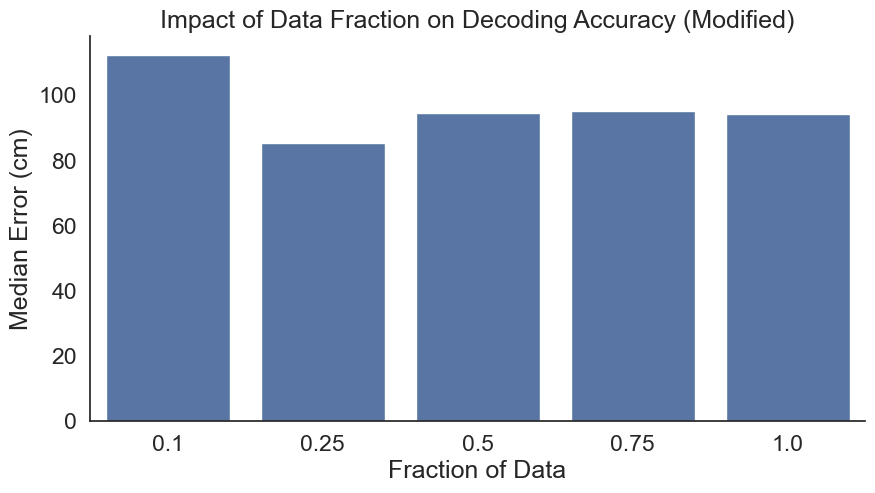

In [14]:
# Function to decode position with the substituted expression
def decode_position_modified(spikes_count, firing_rate_maps, space_bins):
    x_decoded = np.zeros(spikes_count.shape[0])
    for t_bin in range(spikes_count.shape[0]):
        if sum(spikes_count[t_bin,:]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:], firing_rate_maps[:,i] / fps) + pow(10,-15)))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
    return x_decoded

# Sub-sample data and compute median error
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
errors_modified = []

for fraction in fractions:
    sample_size = int(fraction * len(t))
    indices = np.sort(np.random.choice(len(t), sample_size, replace=False))
    sampled_t = t[indices]
    sampled_x = x[indices]

    # Create sub-sampled spike data
    sampled_spikes = []
    for s in spikes:
        sampled_spikes.append(s[np.isin(s, sampled_t)])
    
    # Bin the spikes in the sampled time points
    spikes_count = [np.histogram(s, sampled_t)[0] for s in sampled_spikes]
    spikes_count = np.asarray(spikes_count).T
    
    true_x = sampled_x[:len(spikes_count)]  # Ensure lengths match
    decoded_x = decode_position_modified(spikes_count, firing_rate_maps, space_bins)
    
    mse = np.sqrt((true_x - decoded_x)**2)
    median_error = np.nanmedian(mse)
    errors_modified.append(median_error)

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=fractions, y=errors_modified)
plt.xlabel('Fraction of Data')
plt.ylabel('Median Error (cm)')
plt.title('Impact of Data Fraction on Decoding Accuracy (Modified)')
plt.show()

Yes, there is a difference in the results. The modified approach has a median error of around 110 cm for the 0.1 data fraction, which is higher than the original method's error of less than 100 cm. However, for data fractions from 0.25 to 1, the modified approach has lower median errors (80-90 cm) compared to the original method, which has a median error of around 120 cm. This may suggest that the modified calculation can perform better with larger data fractions, possibly due to the small constant added to avoid log(0) providing a more stable posterior estimation in these cases.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 374.76it/s]


False Positives: 49
False Negatives: 47


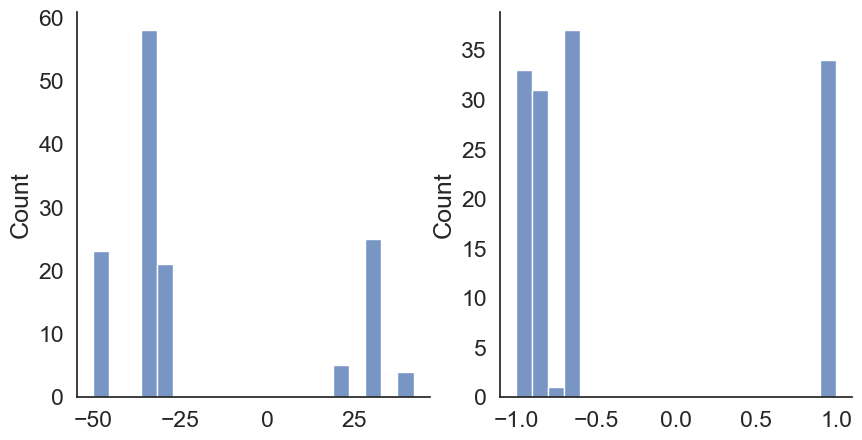

In [20]:
# PART A
# Generate data
n_events = 200  # number of reactivation events
event_duration = 100  # in bins
track_length = 200
n_cells = 100
sampling_rate = 100  # sampling rate
t_react = np.arange(0, event_duration)
noise_x_react = 5  # Noise in the reactivation of the sequence
noise_t_react = 5  # Noise in the timing of the spikes
noise_firing_rate = 0.1  # the baseline noise firing rate

# Ensure space_bins aligns with the length of firing_rate_maps
space_bins = np.linspace(0, track_length, firing_rate_maps.shape[1])

# Simulate reactivation events
reactivation_events = np.zeros((n_events, event_duration))
spikes_react = np.zeros((n_events, n_cells, event_duration))
for event in range(n_events):
    if event < n_events // 2:
        # Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0, track_length)  # Starting point
        x_end = np.random.uniform(0, track_length)  # Ending point
        x_react = np.linspace(x_start, x_end, event_duration) + np.random.normal(0, noise_x_react, size=event_duration)
    else:
        # Pick locations randomly for the second half
        x_react = np.random.uniform(0, track_length, size=event_duration)
        x_react[x_react < 0] = 0
        x_react[x_react > track_length] = track_length
    
    reactivation_events[event, :] = x_react
    
    # Generate spikes according to the location being reactivated
    for i in range(n_cells):
        binned_x = np.digitize(x_react, bins=space_bins) - 1  # Adjust binning to fit array indexing
        inst_rate = firing_rate_maps[i, binned_x] + np.random.normal(0, noise_firing_rate)
        inst_rate[inst_rate < 0] = 0
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        spikes_loc = spikes_loc + np.round(np.random.normal(0, noise_t_react, size=spikes_loc.shape))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc > 0, spikes_loc < event_duration)]
        spikes_react[event, i, spikes_loc.astype(int)] = 1

# Decode the sequences
time_window = 10  # number of bins to aggregate during decoding
reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in tqdm(range(n_events)):
    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells, event_spikes.shape[1] // time_window))
    
    # Generate a new spike matrix with the re-sized window
    for t_r in range(1, event_spikes.shape[1] // time_window):
        spikes_sampled[:, t_r] = np.sum(event_spikes[:, (t_r - 1) * time_window:t_r * time_window], axis=1)
    
    # Perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])
    for t_bin in range(spikes_sampled.shape[1]):
        if sum(spikes_sampled[:, t_bin]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(np.log(poisson.pmf(spikes_sampled[:, t_bin], firing_rate_maps[:, i] / fps) + pow(10, -15)))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
    
    # Remove NaNs for the Pearson correlation calculation
    valid_indices = ~np.isnan(x_decoded)
    if np.sum(valid_indices) > 1:  # Ensure there are enough valid points
        unique_x_decoded = np.unique(x_decoded[valid_indices])
        if len(unique_x_decoded) > 1:  # Ensure there is variation in the data
            slope, _ = np.polyfit(np.arange(len(x_decoded))[valid_indices], x_decoded[valid_indices], deg=1)
            reactivation_slopes[event] = slope

            corr, _ = pearsonr(np.arange(len(x_decoded))[valid_indices], x_decoded[valid_indices])
            reactivation_pvalues[event] = corr
        else:
            reactivation_slopes[event] = np.nan
            reactivation_pvalues[event] = np.nan
    else:
        reactivation_slopes[event] = np.nan
        reactivation_pvalues[event] = np.nan

# Determine the false positives and false negatives
sequence_threshold = 0.05
detected_sequences = reactivation_pvalues < sequence_threshold

true_sequences = np.zeros(n_events, dtype=bool)
true_sequences[:n_events // 2] = True

false_positives = np.sum(detected_sequences & ~true_sequences)
false_negatives = np.sum(~detected_sequences & true_sequences)

print(f'False Positives: {false_positives}')
print(f'False Negatives: {false_negatives}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(reactivation_slopes, bins=20)
plt.subplot(1, 2, 2)
sns.histplot(reactivation_pvalues, bins=20)
plt.show()


In [21]:
# PART B

# Define different noise levels to test
noise_x_react_levels = [1, 5, 10]
noise_t_react_levels = [1, 5, 10]

results = []

for noise_x_react in noise_x_react_levels:
    for noise_t_react in noise_t_react_levels:
        # Simulate reactivation events with different noise levels
        reactivation_events = np.zeros((n_events, event_duration))
        spikes_react = np.zeros((n_events, n_cells, event_duration))
        for event in range(n_events):
            if event < n_events // 2:
                # Generate "real" sequences for the first half of events
                x_start = np.random.uniform(0, track_length)  # Starting point
                x_end = np.random.uniform(0, track_length)  # Ending point
                x_react = np.linspace(x_start, x_end, event_duration) + np.random.normal(0, noise_x_react, size=event_duration)
            else:
                # Pick locations randomly for the second half
                x_react = np.random.uniform(0, track_length, size=event_duration)
                x_react[x_react < 0] = 0
                x_react[x_react > track_length] = track_length

            reactivation_events[event, :] = x_react

            # Generate spikes according to the location being reactivated
            for i in range(n_cells):
                binned_x = np.digitize(x_react, bins=space_bins) - 1  # Adjust binning to fit array indexing
                inst_rate = firing_rate_maps[i, binned_x] + np.random.normal(0, noise_firing_rate)
                inst_rate[inst_rate < 0] = 0
                spikes_loc = np.random.poisson(inst_rate / sampling_rate)
                spikes_loc = spikes_loc + np.round(np.random.normal(0, noise_t_react, size=spikes_loc.shape))
                spikes_loc = spikes_loc[np.logical_and(spikes_loc > 0, spikes_loc < event_duration)]
                spikes_react[event, i, spikes_loc.astype(int)] = 1

        # Decode the sequences
        reactivation_slopes = np.zeros(n_events)
        reactivation_pvalues = np.zeros(n_events)

        for event in tqdm(range(n_events)):
            event_spikes = spikes_react[event]
            spikes_sampled = np.zeros((n_cells, event_spikes.shape[1] // time_window))

            # Generate a new spike matrix with the re-sized window
            for t_r in range(1, event_spikes.shape[1] // time_window):
                spikes_sampled[:, t_r] = np.sum(event_spikes[:, (t_r - 1) * time_window:t_r * time_window], axis=1)

            # Perform decoding on the aggregated spikes
            x_decoded = np.zeros(spikes_sampled.shape[1])
            for t_bin in range(spikes_sampled.shape[1]):
                if sum(spikes_sampled[:, t_bin]) > 0:
                    posterior = np.empty(firing_rate_maps.shape[-1])
                    for i in range(len(posterior)):
                        posterior[i] = sum(np.log(poisson.pmf(spikes_sampled[:, t_bin], firing_rate_maps[:, i] / fps) + pow(10, -15)))
                    x_decoded[t_bin] = space_bins[np.argmax(posterior)]
                else:
                    x_decoded[t_bin] = np.nan

            # Remove NaNs for the Pearson correlation calculation
            valid_indices = ~np.isnan(x_decoded)
            if np.sum(valid_indices) > 1:  # Ensure there are enough valid points
                unique_x_decoded = np.unique(x_decoded[valid_indices])
                if len(unique_x_decoded) > 1:  # Ensure there is variation in the data
                    slope, _ = np.polyfit(np.arange(len(x_decoded))[valid_indices], x_decoded[valid_indices], deg=1)
                    reactivation_slopes[event] = slope

                    corr, _ = pearsonr(np.arange(len(x_decoded))[valid_indices], x_decoded[valid_indices])
                    reactivation_pvalues[event] = corr
                else:
                    reactivation_slopes[event] = np.nan
                    reactivation_pvalues[event] = np.nan
            else:
                reactivation_slopes[event] = np.nan
                reactivation_pvalues[event] = np.nan

        # Determine the false positives and false negatives
        detected_sequences = reactivation_pvalues < sequence_threshold

        true_sequences = np.zeros(n_events, dtype=bool)
        true_sequences[:n_events // 2] = True

        false_positives = np.sum(detected_sequences & ~true_sequences)
        false_negatives = np.sum(~detected_sequences & true_sequences)

        results.append({
            'noise_x_react': noise_x_react,
            'noise_t_react': noise_t_react,
            'false_positives': false_positives,
            'false_negatives': false_negatives
        })

# Print the results
for result in results:
    print(f"Noise x react: {result['noise_x_react']}, Noise t react: {result['noise_t_react']}, False Positives: {result['false_positives']}, False Negatives: {result['false_negatives']}")


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 203.28it/s]

Noise x react: 1, Noise t react: 1, False Positives: 0, False Negatives: 100
Noise x react: 1, Noise t react: 5, False Positives: 52, False Negatives: 51
Noise x react: 1, Noise t react: 10, False Positives: 99, False Negatives: 2
Noise x react: 5, Noise t react: 1, False Positives: 0, False Negatives: 100
Noise x react: 5, Noise t react: 5, False Positives: 54, False Negatives: 49
Noise x react: 5, Noise t react: 10, False Positives: 99, False Negatives: 3
Noise x react: 10, Noise t react: 1, False Positives: 0, False Negatives: 100
Noise x react: 10, Noise t react: 5, False Positives: 58, False Negatives: 49
Noise x react: 10, Noise t react: 10, False Positives: 100, False Negatives: 1


# PART C
the current methods can detect sequences where the animal's position changes consistently and progressively over time. However, they might fail to detect sequences that have rapid, irregular jumps or non-linear progressions, even if those sequences are technically sequential.

An alternative method for sequence detection could involve using Hidden Markov Models (HMMs) to account for more complex temporal dynamics and state transitions. This approach could better capture sequences with more variable or non-linear patterns by modeling the hidden states and their probabilities over time.

### Code for data generation

In [18]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [19]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [24]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [25]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [26]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)